# DMA tutorial: DMA to stream interfaces

This overlay consists of two DMAs and an AXI Stream FIFO (input and output AXI stream interfaces). The FIFO represents an accelerator. A single DMA could be used with a read and write channel enabled, but for demonstration purposes, two different DMAs will be used. 

* The first DMA with read channel enabled is connected from DDR to IP input stream (reading from DDR, and sending to AXI stream).
* The second DMA has a write channel enabled and is connected to IP output stream to DDR (receiving from AXI stream, and writing to DDR memory).


![](images/dma_stream_example.png)

## 1. Downloading overlay
The overlay can be downloaded automatically when instantiating an overlay class.

In [205]:
from pynq import Overlay, allocate
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [206]:
overlay = Overlay("./bitstream/FinalProject2.bit")
image_path = "reflect.jpg"
original_image = Image.open(image_path)

We can check the IPs in this overlay. Notice the DMAs *axi_dma_from_pl_to_ps* and *axi_dma_from_pl_to_ps*.

In [207]:
overlay.ip_dict

{'axi_dma_from_pl_to_ps': {'addr_range': 65536,
  'device': <pynq.pl_server.device.XlnkDevice at 0xafb701b0>,
  'driver': pynq.lib.dma.DMA,
  'fullpath': 'axi_dma_from_pl_to_ps',
  'gpio': {},
  'interrupts': {},
  'mem_id': 'S_AXI_LITE',
  'parameters': {'C_BASEADDR': '0x40400000',
   'C_DLYTMR_RESOLUTION': '125',
   'C_ENABLE_MULTI_CHANNEL': '0',
   'C_FAMILY': 'zynq',
   'C_HIGHADDR': '0x4040FFFF',
   'C_INCLUDE_MM2S': '0',
   'C_INCLUDE_MM2S_DRE': '0',
   'C_INCLUDE_MM2S_SF': '1',
   'C_INCLUDE_S2MM': '1',
   'C_INCLUDE_S2MM_DRE': '0',
   'C_INCLUDE_S2MM_SF': '1',
   'C_INCLUDE_SG': '0',
   'C_INCREASE_THROUGHPUT': '0',
   'C_MICRO_DMA': '0',
   'C_MM2S_BURST_SIZE': '16',
   'C_M_AXIS_MM2S_CNTRL_TDATA_WIDTH': '32',
   'C_M_AXIS_MM2S_TDATA_WIDTH': '32',
   'C_M_AXI_MM2S_ADDR_WIDTH': '32',
   'C_M_AXI_MM2S_DATA_WIDTH': '32',
   'C_M_AXI_S2MM_ADDR_WIDTH': '32',
   'C_M_AXI_S2MM_DATA_WIDTH': '32',
   'C_M_AXI_SG_ADDR_WIDTH': '32',
   'C_M_AXI_SG_DATA_WIDTH': '32',
   'C_NUM_MM2S_CHANNE

## 2. Create DMA instances

Using the labels for the DMAs listed above, we can create two DMA objects.

In [208]:
import pynq.lib.dma

dma_send = overlay.axi_dma_from_ps_to_pl
dma_recv = overlay.axi_dma_from_pl_to_ps

## 3. Read DMA
We will read some data from memory, and write to FIFO in the following cells.

The first step is to allocate the buffer. pynq.allocate will be used to allocate the buffer, and NumPy will be used to specify the type of the buffer. 

In [209]:
from pynq import allocate
import numpy as np

data_size = 2560
input_buffer = allocate(shape=(data_size,), dtype=np.uint32)
print(type(input_buffer))


<class 'pynq.buffer.PynqBuffer'>


The array can be used like any other NumPy array. We can write some test data to the array. Later the data will be transferred by the DMA to the FIFO. 

Max size of the first dimension: 40
Max size of the second dimension: 64
(40, 64, 3)
Image Array 1 [[68 70 71 ... 69 61 51]
 [75 78 79 ... 72 68 64]
 [76 82 87 ... 84 85 79]
 ...
 [40 44 46 ... 41 38 32]
 [33 38 40 ... 36 33 28]
 [25 30 33 ... 28 26 19]]
Image Array 2 [[130 136 144 ... 143 136 129]
 [139 144 151 ... 142 139 136]
 [146 152 157 ... 150 145 137]
 ...
 [110 114 118 ... 112 108 102]
 [103 108 113 ... 106 103  95]
 [ 95 100 106 ...  98  93  86]]
Image Array 3 [[207 214 223 ... 232 217 204]
 [211 218 227 ... 227 217 210]
 [206 214 226 ... 226 218 210]
 ...
 [208 212 216 ... 200 196 190]
 [199 204 208 ... 194 189 182]
 [190 195 201 ... 186 180 173]]
32-Bit Colorpixel [[4489935 4622550 4690143 ... 4558824 4032729 3375564]
 [4950995 5148890 5216227 ... 4755171 4492249 4229330]
 [5018318 5413078 5742050 ... 5543650 5607898 5212626]
 ...
 [2649808 2912980 3045080 ... 2715848 2518212 2123454]
 [2189255 2518220 2650576 ... 2386626 2189245 1859510]
 [1662910 1991875 2190025 ... 18602

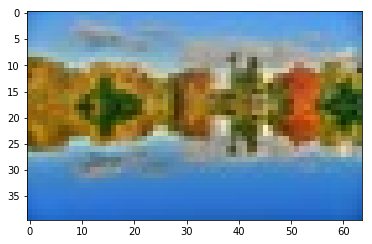

In [210]:

img_array = np.asarray(original_image)
max_size_dim1 = img_array.shape[0]  # Maximum size of the first dimension
max_size_dim2 = img_array.shape[1]  # Maximum size of the second dimension

print("Max size of the first dimension:", max_size_dim1)
print("Max size of the second dimension:", max_size_dim2)
print(img_array.shape)




COLORPIXEL32 = np.zeros((max_size_dim1, max_size_dim2), dtype=np.uint32)

print("Image Array 1",img_array[:,:,0])
print("Image Array 2",img_array[:,:,1])
print("Image Array 3",img_array[:,:,2])


for i in range(max_size_dim1):
    for j in range(max_size_dim2):
        COLORPIXEL32[i,j] = np.uint32((img_array[i,j,0] << 16) + (img_array[i,j,1] << 8) + img_array[i,j,2])


##_ = plt.imshow(img_array, cmap='gray')

print("32-Bit Colorpixel", COLORPIXEL32)
print ("32-Bit Colorpixel Shape", COLORPIXEL32.shape)

_ = plt.imshow(img_array, cmap='gray')
reshaped_array = np.reshape(COLORPIXEL32, -1)  
input_buffer_temp = reshaped_array.astype(np.uint32)
print(input_buffer_temp)
for i in range(data_size):
    input_buffer[i]=input_buffer_temp[i]
print(type(input_buffer))

print(reshaped_array)
print(input_buffer)
print(input_buffer.shape)

Let's check the contents of the array. The data in the following cell will be sent from PS (DDR memory) to PL (streaming FIFO).

### Print first few values of buffer 

In [211]:
max_value = input_buffer[0]
for i in range(data_size):
    if input_buffer[i] > max_value:
        max_value = input_buffer[i]

# Print the maximum value
print("Maximum value in the input buffer:", max_value)


Maximum value in the input buffer: 16774333


Now we are ready to carry out DMA transfer from a memory block in DDR to FIFO.

In [212]:
dma_send.sendchannel.transfer(input_buffer)

## 4. Write DMA
Let's read the data back from FIFO stream, and write to MM memory. The steps are similar.

We will prepare an empty array before reading data back from FIFO.

### Print first few values of buffer 

In [213]:
output_buffer = allocate(shape=(data_size,), dtype=np.uint32)

for i in range(10):
    print('0x' + format(output_buffer[i], '02x'))

0x00
0x00
0x00
0x00
0x00
0x00
0x00
0x00
0x00
0x00


In [214]:
dma_recv.recvchannel.transfer(output_buffer)

The next cell will print out the data received from PL (streaming FIFO) to PS (DDR memory). This should be the same as the data we sent previously.

### Print first few values of buffer 

In [215]:
for i in range(data_size):
    print('0x' + format(output_buffer[i], '02x'))

0x00
0x00
0x00
0x00
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4b9be2
0x4d9be2
0x539be2
0x569be3
0x579be2
0x579bdf
0x529bde
0x529bd9
0x539be2
0x579de2
0x579be2
0x579bd8
0x579bd9
0x5a9bdf
0x5a9be2
0x599be3
0x589be4
0x569be4
0x559be2
0x559de2
0x539de2
0x539ee2
0x529ee2
0x529ee3
0x549ce5
0x549ce6
0x589ce7
0x589ce7
0x579be3
0x579be2
0x589be2
0x589be2
0x589be4
0x589be9
0x569ce6
0x539de6
0x539de8
0x4f9beb
0x4f9beb
0x509bea
0x539be7
0x559be6

0x655b16
0x74621f
0x8d853c
0x827a27
0x6d5d10
0x5e530f
0x60530f
0x7e420f
0xa0420f
0xb74b0f
0xc14c0e
0xc8590f
0xbe5d0f
0xb8600f
0x8b6612
0x776612
0x526112
0x244402
0x173f07
0x163e08
0x1e440a
0x395a0a
0x97650b
0x976c11
0x946b11
0x936b11
0x926a0d
0x926a0b
0x8f6a0b
0x926c0c
0x9d700e
0x9c700e
0x996c0e
0x8c6a0b
0x5c6108
0x515b06
0x314000
0x223d00
0x314c03
0x585809
0x6a630f
0x976c12
0x966c15
0x916114
0x905d10
0x906810
0x91711a
0x91751e
0x86711a
0x625813
0x624d13
0x6b4715
0x805319
0x8f5317
0x8f5012
0x8f5d14
0x9e6a2f
0xb08d67
0xc0ae7e
0xc0b390
0xaaab7b
0x71742f
0x545a1b
0x54500f
0x48500b
0x655b16
0x827a27
0x8d853c
0x6b5620
0x60520d
0x684f0d
0x7e420d
0x9c420f
0xac420f
0xb7420e
0xb74c0e
0xb86010
0xb1610f
0x8c6c0f
0x7e6d0c
0x65660c
0x405609
0x324406
0x284407
0x39530a
0x706c0a
0x976d0b
0x9c7014
0xa47414
0x946f0e
0x906a0b
0x8a650b
0x855c09
0x745309
0x865b0e
0x936a15
0x936b17
0x996c17
0x8e6e15
0x5c5b06
0x453d00
0x383d00
0x585801
0x86630f
0xae7f25
0xae7c2a
0xa3742a
0x915f1a
0x875a16
0x8e5a1a
0x988562
0

0x3075d3
0x3075d3
0x2f74d3
0x2f74d3
0x2f74d3
0x3075d3
0x3075d3
0x3075d3
0x3075d3
0x2f74d2
0x2f74d2
0x2e74d1
0x2e74d2
0x2e74d1
0x2e74d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d1
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2e73d0
0x2c74d0
0x2b74d0
0x2b74d0
0x2b73cf
0x2c73cf
0x2c72cf
0x2c71cf
0x2b71ce
0x2b72ce
0x2972ce
0x2974ce
0x2a74ce
0x2a74ce
0x2a74ca
0x2972c9
0x276ec6
0x266dc6
0x266dcc
0x2b71d1
0x2e75d5
0x2e78da
0x2d78da
0x2c78d9
0x2c76d6
0x2c75d6
0x2c74d4
0x2e74d4
0x3074d4
0x3074d4
0x2e74d5
0x2d73d5
0x2b73d7
0x2b73d5
0x2d73d3
0x2d72d3
0x2d72d2
0x2d71d2
0x2d72d1
0x2d72d1
0x2d72d1
0x2d72d1
0x2d72d1
0x2d72d1
0x2d72d1
0x2c72ce
0x2b72ce
0x2b72ce
0x2b72ce
0x2b72ce
0x2b70cd
0x2b70cd
0x2b70cd
0x2b70cd
0x2b70cd
0x2b70cd
0x2b70cd
0x2b70cd
0x2c71ce
0x2c71ce
0x2c71ce
0x2c71ce
0x2b70cd
0x2b70cd
0x2b70cd
0x2b70cd
0x2a70cf
0x2a70cf
0x2a70cf
0x2a70cf
0x2a70ce
0x2a6fce
0x2a6fce
0x296fce
0x2870cd
0x2871cd
0x2873cd
0x2973ca
0x2872c9
0x276ec6
0x246ac2
0x2167c0
0

Verify that the arrays are equal

rgb Image shape (40, 64, 3)
rgb Image R [[ 0  0  0 ... 75 75 75]
 [75 75 75 ... 78 77 75]
 [75 69 75 ... 79 79 78]
 ...
 [42 42 42 ... 42 42 42]
 [41 39 38 ... 40 41 40]
 [39 36 33 ... 36 37 37]]
rgb Image G [[  0   0   0 ... 155 155 155]
 [155 155 155 ... 155 154 151]
 [146 142 139 ... 157 154 150]
 ...
 [117 114 113 ... 116 116 116]
 [114 110 109 ... 115 115 114]
 [110 106 103 ... 109 109 108]]
rgb Image B [[  0   0   0 ... 226 226 226]
 [226 226 226 ... 235 235 232]
 [226 226 217 ... 237 236 234]
 ...
 [202 199 199 ... 206 206 202]
 [201 198 198 ... 205 202 201]
 [198 194 192 ... 200 200 196]]


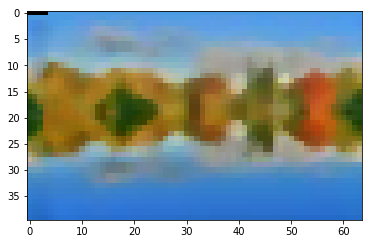

In [216]:
# Assuming output_buffer contains 32-bit integers with packed RGB data
reshaped_array_temp = output_buffer.reshape((40, 64))  # Reshape to image dimensions

# Extract RGB components from the output buffer
red = (reshaped_array_temp >> 16) & 0xFF
green = (reshaped_array_temp >> 8) & 0xFF
blue = reshaped_array_temp & 0xFF

# Reshape each color component to the correct image dimensions
reshaped_Red = red.reshape(40, 64)
reshaped_Green = green.reshape(40, 64)
reshaped_Blue = blue.reshape(40, 64)

# Create an RGB image
rgb_image = np.empty((40, 64, 3), dtype=np.uint8)
rgb_image[:, :, 0] = reshaped_Red
rgb_image[:, :, 1] = reshaped_Green
rgb_image[:, :, 2] = reshaped_Blue

# Display the RGB image
print("rgb Image shape", rgb_image.shape)
print("rgb Image R", reshaped_Red)
print("rgb Image G", reshaped_Green)
print("rgb Image B", reshaped_Blue)

_ = plt.imshow(rgb_image)
plt.show()  # Make sure to use plt.show() to display the plot


## 6. Free all the memory buffers
Don't forget to free the memory buffers to avoid memory leaks!

In [217]:
del input_buffer, output_buffer